In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/aaravnair/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aaravnair/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
property_df = pd.read_parquet("../../data/raw/property_details_w_distances.parquet")

In [3]:
columns_to_drop = ['title', 'description', 'street_address', 'suburb', 
                    'structured_features', 'video_count', 'floor_plans_count',
                   'date_listed', 'virtual_tour', 'latitude', 'longitude', 'primary_property_type']

In [4]:
target = np.array(property_df['price']) # target variable
features = np.array(property_df.drop(columns=columns_to_drop+['price']))
feature_list = list(property_df.drop(columns=columns_to_drop+['price']).columns)

In [5]:
# Taken from https://towardsdatascience.com/ai-and-real-state-renting-in-amsterdam-part-1-5fce18238dbc

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=10,random_state=30034,shuffle=True)
accuracies = []
for train_index, test_index in kf.split(features):

    data_train   = features[train_index]
    target_train = target[train_index]

    data_test    = features[test_index]
    target_test  = target[test_index]


    # Paramets found using hyperparameter tuning (shown later in the notebook)
    rf = RandomForestRegressor(n_estimators = 400, 
                                random_state = 30034, 
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_features = 'sqrt',
                                max_depth = None,
                                bootstrap=False)
    
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(predictions - target_test)

    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)

print('\nAverage accuracy:', np.mean(accuracies))

/Users/aaravnair/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Mean Absolute Error: 121.88
Accuracy: 75.5 %.
Mean Absolute Error: 119.84
Accuracy: 81.31 %.
Mean Absolute Error: 171.01
Accuracy: 82.81 %.
Mean Absolute Error: 116.95
Accuracy: 59.27 %.
Mean Absolute Error: 184.69
Accuracy: 80.41 %.
Mean Absolute Error: 241.82
Accuracy: 74.74 %.
Mean Absolute Error: 118.68
Accuracy: 79.3 %.
Mean Absolute Error: 123.95
Accuracy: 82.58 %.
Mean Absolute Error: 128.0
Accuracy: 68.02 %.
Mean Absolute Error: 151.02
Accuracy: 68.3 %.

Average accuracy: 75.22301224170893


In [6]:
test_hyperparameters = False

if test_hyperparameters:
    from sklearn.model_selection import RandomizedSearchCV
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    random_grid
    # Use the random grid to search for best hyperparameters
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(data_train, target_train)

    print(rf_random.best_params_)

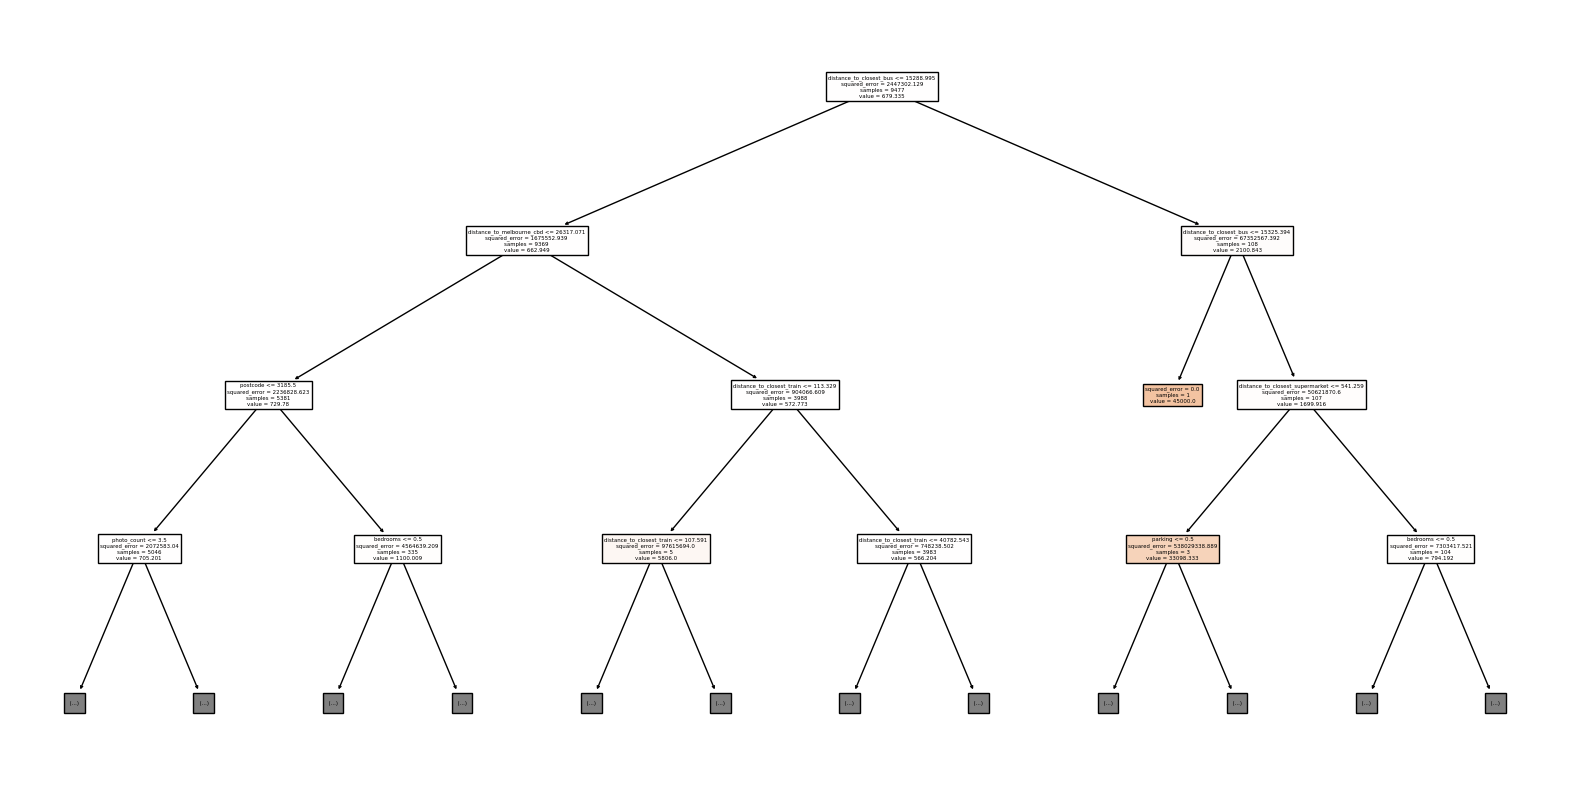

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=feature_list, filled=True, max_depth=3)
plt.savefig('../../plots/decision_tree.png')
plt.show()

In [8]:
y = rf.feature_importances_
list_y = [a for a in y if a > 0.005]
print(list_y)

list_of_index = []
for i in list_y:
    a = np.where(y==i)
    list_of_index.append(a)
print(list_of_index)
list_of_index = [0,1,2,3,4,5,6,7,8,9,10,11]

[0.04666741032726264, 0.25457590775769284, 0.017286856506668034, 0.04657216444781947, 0.0461022699925183, 0.07937880719338423, 0.04899153058280254, 0.08541540664037726, 0.07066888195710448, 0.09676259529022158, 0.10256021673654032, 0.10501795256760839]
[(array([0]),), (array([1]),), (array([2]),), (array([3]),), (array([4]),), (array([5]),), (array([6]),), (array([7]),), (array([8]),), (array([9]),), (array([10]),), (array([11]),)]


In [9]:
col = []
for i in feature_list:
    col.append(i)
labels = []
for i in list_of_index:
    b = col[i]
    labels.append(b)

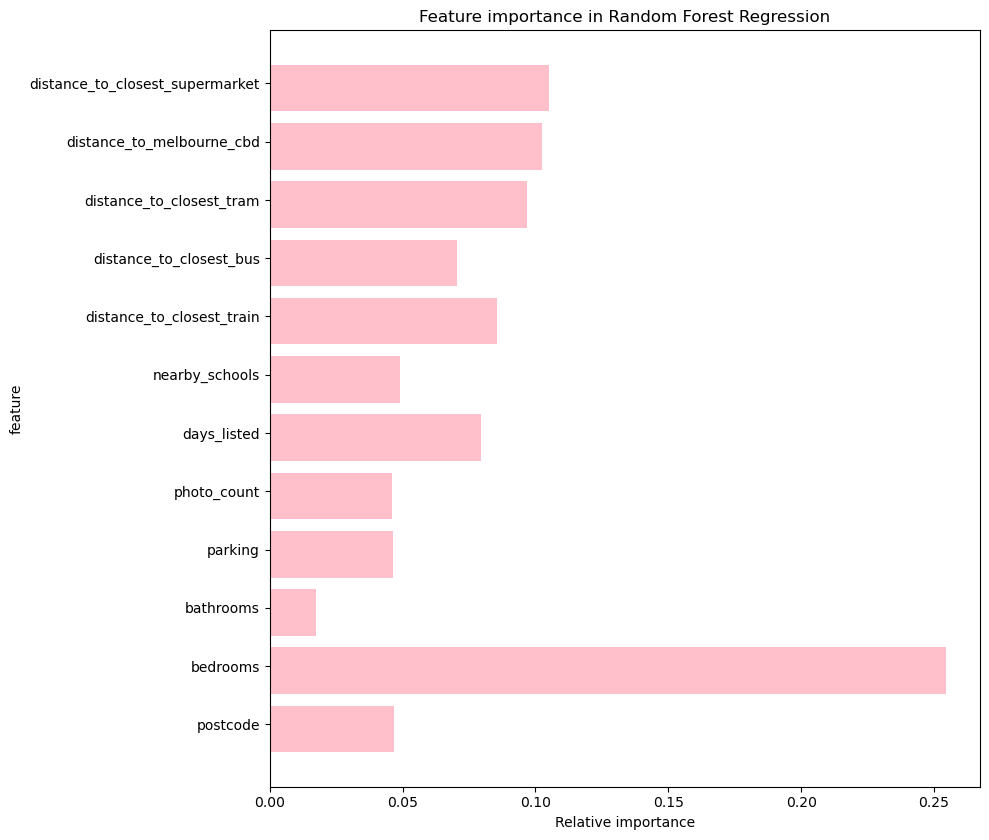

In [10]:
y = list_y
fig, ax = plt.subplots() 
width = 0.8
ind = np.arange(len(y)) 
ax.barh(ind, y,width, color="pink")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(labels, minor=False)
plt.title('Feature importance in Random Forest Regression')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
fig.set_size_inches(10, 8.5, forward=True)
plt.tight_layout()
plt.savefig('../../plots/feature_importance.png')
plt.show()


In [11]:
# Other models: ------------------

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Split the data (70% train, 30% test)
data_train, data_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=30034)

# Function to evaluate a model
def evaluate_model(model, data_train, target_train, data_test, target_test):
    model.fit(data_train, target_train)
    predictions = model.predict(data_test)
    errors = abs(predictions - target_test)
    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

# RandomForestRegressor
print("RandomForestRegressor:")
rf = RandomForestRegressor(n_estimators=400, random_state=30034, max_features='sqrt', max_depth=None)
evaluate_model(rf, data_train, target_train, data_test, target_test)

# GradientBoostingRegressor
print("\nGradientBoostingRegressor:")
gb = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=30034)
evaluate_model(gb, data_train, target_train, data_test, target_test)

# Lasso
print("\nLasso:")
lasso = Lasso(alpha=0.01, random_state=30034)
evaluate_model(lasso, data_train, target_train, data_test, target_test)

# Ridge
print("\nRidge:")
ridge = Ridge(alpha=1.0, random_state=30034)
evaluate_model(ridge, data_train, target_train, data_test, target_test)

# XGBoost
print("\nXGBoost:")
xgb = XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=3, random_state=30034)
evaluate_model(xgb, data_train, target_train, data_test, target_test)

# Support Vector Regressor
print("\nSupport Vector Regressor:")
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
evaluate_model(svr, data_train, target_train, data_test, target_test)

# K-Nearest Neighbors Regressor
print("\nK-Nearest Neighbors Regressor:")
knn = KNeighborsRegressor(n_neighbors=5)
evaluate_model(knn, data_train, target_train, data_test, target_test)

# Decision Tree Regressor
print("\nDecision Tree Regressor:")
tree = DecisionTreeRegressor(random_state=30034, max_depth=None)
evaluate_model(tree, data_train, target_train, data_test, target_test)

# ElasticNet
print("\nElasticNet:")
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=30034)
evaluate_model(elasticnet, data_train, target_train, data_test, target_test)

# AdaBoost
print("\nAdaBoost:")
adaboost = AdaBoostRegressor(n_estimators=400, learning_rate=0.1, random_state=30034)
evaluate_model(adaboost, data_train, target_train, data_test, target_test)


RandomForestRegressor:
Mean Absolute Error: 152.0
Accuracy: 79.56 %.

GradientBoostingRegressor:
Mean Absolute Error: 147.12
Accuracy: 79.04 %.

Lasso:
Mean Absolute Error: 262.45
Accuracy: 63.79 %.

Ridge:
Mean Absolute Error: 262.46
Accuracy: 63.78 %.

XGBoost:


/Users/aaravnair/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.505e+09, tolerance: 1.949e+06
  model = cd_fast.enet_coordinate_descent(


Mean Absolute Error: 185.06
Accuracy: 70.68 %.

Support Vector Regressor:
Mean Absolute Error: 224.67
Accuracy: 73.46 %.

K-Nearest Neighbors Regressor:
Mean Absolute Error: 241.8
Accuracy: 66.0 %.

Decision Tree Regressor:
Mean Absolute Error: 186.96
Accuracy: 70.18 %.

ElasticNet:


/Users/aaravnair/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.506e+09, tolerance: 1.949e+06
  model = cd_fast.enet_coordinate_descent(


Mean Absolute Error: 262.06
Accuracy: 63.87 %.

AdaBoost:
Mean Absolute Error: 330.44
Accuracy: 45.56 %.


In [12]:
from sklearn.ensemble import GradientBoostingRegressor

kf = KFold(n_splits=10, random_state=30034, shuffle=True)
gb_accuracies = []

for train_index, test_index in kf.split(features):
    data_train = features[train_index]
    target_train = target[train_index]
    data_test = features[test_index]
    target_test = target[test_index]

    # Gradient Boosting Regressor model
    gb = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=30034, max_depth=3)

    gb.fit(data_train, target_train)
    predictions = gb.predict(data_test)

    errors = abs(predictions - target_test)
    print('Mean Absolute Error (Gradient Boosting):', round(np.mean(errors), 2))

    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy (Gradient Boosting):', round(accuracy, 2), '%.')

    gb_accuracies.append(accuracy)

print('\nAverage accuracy (Gradient Boosting):', np.mean(gb_accuracies))


Mean Absolute Error (Gradient Boosting): 125.32
Accuracy (Gradient Boosting): 78.52 %.
Mean Absolute Error (Gradient Boosting): 143.91
Accuracy (Gradient Boosting): 74.26 %.
Mean Absolute Error (Gradient Boosting): 175.26
Accuracy (Gradient Boosting): 81.77 %.
Mean Absolute Error (Gradient Boosting): 127.24
Accuracy (Gradient Boosting): 52.34 %.
Mean Absolute Error (Gradient Boosting): 198.23
Accuracy (Gradient Boosting): 78.7 %.
Mean Absolute Error (Gradient Boosting): 256.86
Accuracy (Gradient Boosting): 73.8 %.
Mean Absolute Error (Gradient Boosting): 118.93
Accuracy (Gradient Boosting): 79.83 %.
Mean Absolute Error (Gradient Boosting): 158.44
Accuracy (Gradient Boosting): 78.62 %.
Mean Absolute Error (Gradient Boosting): 145.39
Accuracy (Gradient Boosting): 72.06 %.
Mean Absolute Error (Gradient Boosting): 157.62
Accuracy (Gradient Boosting): 71.6 %.

Average accuracy (Gradient Boosting): 74.14950935051857


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Instantiate the RandomForestRegressor
rf = RandomForestRegressor(random_state=30034)

# Set up RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid,
                               n_iter=50, cv=5, verbose=2, random_state=30034, n_jobs=-1)

# Perform the search
rf_random.fit(data_train, target_train)

# Get the best parameters
print("Best parameters for RandomForestRegressor:", rf_random.best_params_)

# Evaluate on the test data
best_rf = rf_random.best_estimator_
rf_predictions = best_rf.predict(data_test)
rf_mae = np.mean(abs(rf_predictions - target_test))
print(f"RandomForestRegressor MAE: {rf_mae}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   7.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   7.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   7.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators

In [ ]:
#Best parameters for RandomForestRegressor: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'learning_rate': [0.01, 0.1, 0.05, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt']
}

# Instantiate the GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=30034)

# Set up RandomizedSearchCV
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=gb_param_grid,
                               n_iter=50, cv=5, verbose=2, random_state=30034, n_jobs=-1)

# Perform the search
gb_random.fit(data_train, target_train)

# Get the best parameters
print("Best parameters for GradientBoostingRegressor:", gb_random.best_params_)

# Evaluate on the test data
best_gb = gb_random.best_estimator_
gb_predictions = best_gb.predict(data_test)
gb_mae = np.mean(abs(gb_predictions - target_test))
print(f"GradientBoostingRegressor MAE: {gb_mae}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END lear

In [27]:
from sklearn.model_selection import GridSearchCV

# Example with Random Forest
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(data_train, target_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  16.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estim

/Users/aaravnair/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.6min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  27.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.5min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  28.8s
[CV] END bootstrap=False, m

KeyboardInterrupt: 